In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [24]:
import numpy as np
import pandas as pd

In [25]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [27]:
## set up engine and connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite")



In [28]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [29]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
mt = Base.classes.measurement
st = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [32]:
inspector=inspect(engine)

# # ##--------------------------------------------
m_columns=inspector.get_columns('measurement')

s_columns=inspector.get_columns('station')

print("measurement")
for m in m_columns:
    print(m)
    # print(m['name'],m['type'])
print('-----')
print("station")
for s in s_columns:
    print(s)



measurement
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
-----
station
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, '

In [33]:
#finds the station id for the honolulu station
hon_sta_id=engine.execute("SELECT station from station WHERE name like '%Honolulu%'").fetchall()[0][0]



# Exploratory Climate Analysis

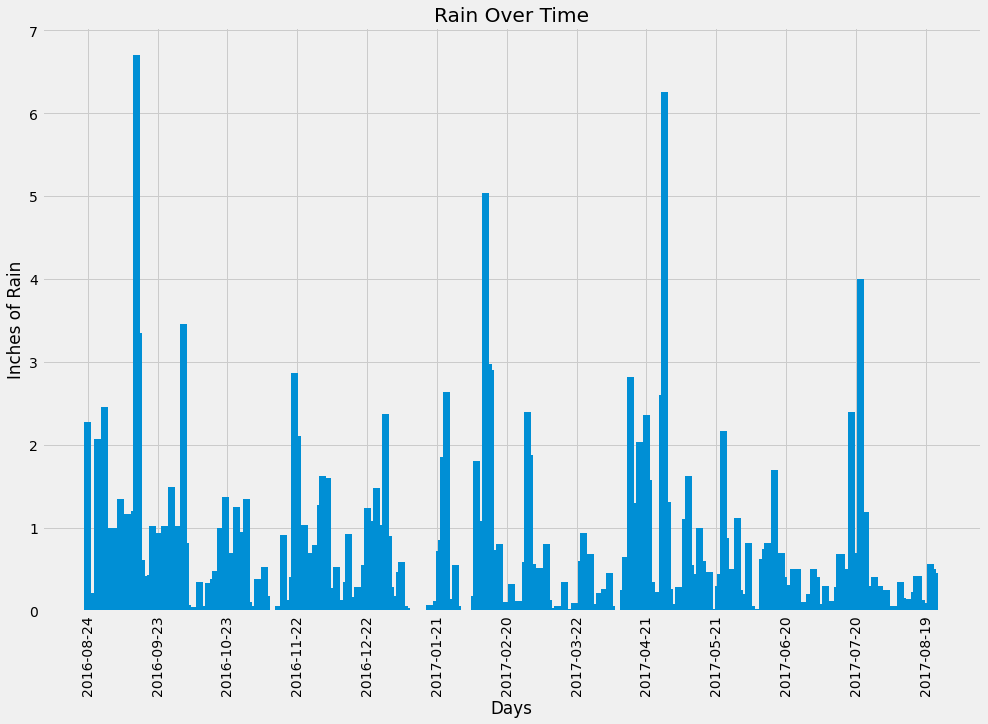

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

####getting the max day from the measurement table and converting it into datetime format

max_date = session.query(func.max(mt.date)).first()[0]
max_date = dt.datetime.strptime(max_date,'%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
year_ago =(max_date - dt.timedelta(weeks=52)).replace(day=max_date.day)

##### converting it into a format that we're able to query with
year_ago = f'{year_ago.year}-{year_ago.month:02d}-{year_ago.day:02d}'

# Perform a query to retrieve the data and precipitation amounts
annual_pre_list = session.query(mt.date,mt.prcp).filter(mt.date>year_ago).all()

year_list =[pd.to_datetime(x,format='%Y-%m-%d') for x,y in annual_pre_list]
precip_list = [y for x,y in annual_pre_list]

# Save the query results as a Pandas DataFrame and set the index to the date column &  Sort the dataframe by date, and remove null values
annual_pre_df = pd.DataFrame({"precipitation":precip_list},index=year_list).sort_index().dropna()
# # Use Pandas Plotting with Matplotlib to plot the data

#### defining x ticks as every 30 days
x_ticks=[annual_pre_df.index[0]]
for x in range(12):
    new_date = x_ticks[-1] + dt.timedelta(days=30)
    x_ticks.append(new_date)

###plotting
plt.figure(figsize=(15,10))
plt.bar(annual_pre_df.index,annual_pre_df.precipitation,width=3)
plt.xticks(x_ticks,rotation='vertical')
plt.xlabel("Days")
plt.ylabel("Inches of Rain")
plt.title("Rain Over Time")

#saving an image of the plot
plt.savefig('Images/rainChart.png')

## displaying the plot
plt.show()



In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
annual_pre_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [36]:
# Design a query to show how many stations are available in this dataset
station_count = engine.execute("SELECT COUNT(station.id) FROM station").fetchall()[0][0]
print(f'There are {station_count} stations in the dataset')

There are 9 stations in the dataset


In [37]:
# What are the most active stations? (i.e. what stations have the most rows)?
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


station_activity_list = engine.execute("SELECT DISTINCT station, (SELECT COUNT(measurement.id) FROM measurement WHERE measurement.station=station.station) as meas_count,(SELECT MAX(measurement.tobs) FROM measurement WHERE measurement.station=station.station) as max_temp,(SELECT MIN(measurement.tobs)FROM measurement WHERE measurement.station=station.station) as min_temp,ROUND((SELECT AVG(measurement.tobs)FROM measurement WHERE measurement.station=station.station),2) as avg_temp, name FROM station ORDER BY meas_count DESC").fetchall()


station_summary_df=pd.DataFrame(station_activity_list,columns=['station','measurement_count','max_temp','min_temp','avg_temp','name'])



# List the stations and the counts in descending order.
print(f'There are {station_count} stations in the dataset. {station_summary_df["name"][0]} is the most active station with {station_summary_df["measurement_count"][0]} measurements recorded')
station_summary_df


There are 9 stations in the dataset. WAIHEE 837.5, HI US is the most active station with 2772 measurements recorded


,station,measurement_count,max_temp,min_temp,avg_temp,name
0,USC00519281,2772,85.0,54.0,71.66,"WAIHEE 837.5, HI US"
1,USC00519397,2724,87.0,56.0,74.55,"WAIKIKI 717.2, HI US"
2,USC00513117,2709,85.0,59.0,72.69,"KANEOHE 838.1, HI US"
3,USC00519523,2669,85.0,56.0,74.54,"WAIMANALO EXPERIMENTAL FARM, HI US"
4,USC00516128,2612,84.0,58.0,70.92,"MANOA LYON ARBO 785.2, HI US"
5,USC00514830,2202,85.0,58.0,74.87,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
6,USC00511918,1979,87.0,53.0,71.62,"HONOLULU OBSERVATORY 702.2, HI US"
7,USC00517948,1372,87.0,58.0,74.68,"PEARL CITY, HI US"
8,USC00518838,511,83.0,58.0,72.72,"UPPER WAHIAWA 874.3, HI US"


356
356


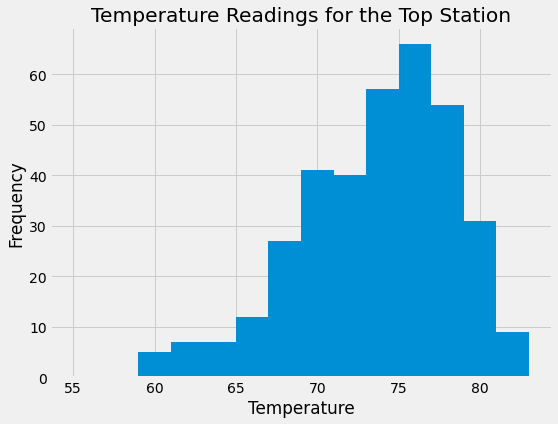

In [41]:
# Choose the station with the highest number of temperature observations.
top_station=station_summary_df["station"][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

### find the first and last date we'll be plotting
top_last_date = dt.datetime.strptime(session.query(mt.date,mt.tobs).filter(mt.station==top_station).order_by(mt.date.desc()).first()[0],'%Y-%m-%d')

top_first_date = top_last_date - dt.timedelta(days=365)


##### using the first and last date for the top station, query the temp data
top_station_temps_df=pd.DataFrame(session.query(mt.date,mt.tobs).filter(mt.station==top_station,mt.date>top_first_date).all())

###making the date he index
top_station_temps_df.set_index('date',inplace=True)


print(len(top_station_temps_df))
top_station_temps_df.dropna(inplace=True)



bin=np.arange(55,85,2)
bin
print(len(top_station_temps_df))
fig,ax=plt.subplots(figsize=(8,6))
ax.hist(top_station_temps_df.tobs,bins=bin)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Readings for the Top Station")

#saving an image of the plot
plt.savefig('Images/stationChart.png')

plt.show()


## Bonus Challenge Assignment

In [39]:
#bonus
## querys all the date and temperature readings
monthly_comp_df=pd.DataFrame(session.query(mt.date,mt.tobs).all())

## creates a column with the numeric month
monthly_comp_df["month_num"]=[i[5:7] for i in monthly_comp_df["date"]]

## finds the mean temp for each month
monthly_comp_df=monthly_comp_df.groupby("month_num").agg(['min','max','mean'])

## drops the multilevel index
monthly_comp_df.columns =monthly_comp_df.columns.droplevel()

##rename columns
monthly_comp_df.rename(columns={
    'min':'min_temp',
    'max':'max_temp',
    'mean':'mean_temp'
})



## get or create a dictionary that has numeric month and written month

month_names=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# #turns the index from the dataframe into a list
# month_num_list=monthly_comp_df.index.to_list()

# ### creates a dictionary of numeric months and month abreviations
# month_switch_dict={month_num_list[x]:month_names[x] for x in range(len(month_names))}

#uses the dictionary to rename the index
# monthly_comp_df.rename(index=month_switch_dict)


monthly_comp_df['month']=month_names

monthly_comp_df.set_index('month',inplace=True)
monthly_comp_df



,min,max,mean
month,,,
Jan,54.0,81.0,68.726115
Feb,56.0,83.0,69.442236
Mar,56.0,82.0,70.059067
Apr,53.0,84.0,72.357268
May,63.0,87.0,73.680900
Jun,64.0,85.0,74.944118
Jul,61.0,87.0,76.082408
Aug,65.0,87.0,76.412454
Sep,64.0,87.0,76.164865


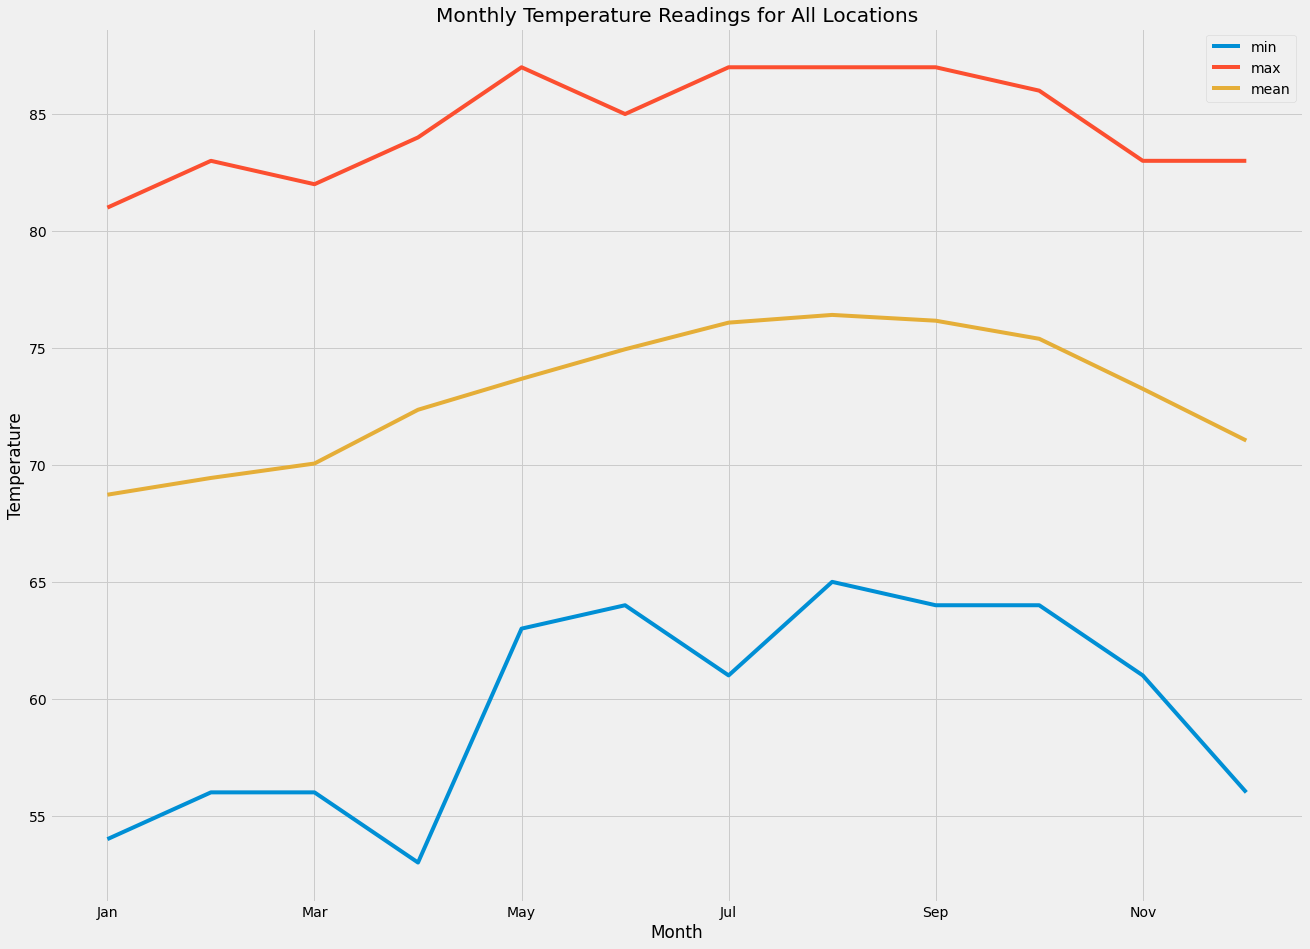

In [40]:
## plotting previous df



monthly_comp_chart=monthly_comp_df.plot(kind='line', figsize=(20,15), title="Monthly Temperature Readings for All Locations")


monthly_comp_chart.set_xlabel("Month")
monthly_comp_chart.set_ylabel("Temperature")

#saving an image of the plot
plt.savefig('Images/monthlyTempChart.png')

monthly_comp_chart